In [289]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import datetime as dt
import warnings
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR, AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from pmdarima import auto_arima


freq_metric = 'h'
#raw = pd.read_csv('s1090_720_main_station.csv', sep = ',')
raw = pd.read_csv('s1046_720_adjacent_stations.csv', sep = ',')
print('\033[1mRaw dataframe:\033[0m \n',raw)

Raw dataframe: 
      main_aqi           co      pm_2_5       pm_10               dt2  s1090  \
0         167  1572.050000  126.410000  231.710000  05:00_19/11/2021    181   
1         173  1519.020000  121.310000  225.760000  06:00_19/11/2021    170   
2         170  1192.600000  103.240000  187.170000  07:00_19/11/2021    178   
3         165  1127.420000   94.610000  171.610000  08:00_19/11/2021    164   
4         168  1268.710000  108.540000  196.060000  09:00_19/11/2021    159   
..        ...          ...         ...         ...               ...    ...   
715       135   625.499048   83.095198  150.759048  00:00_19/12/2021    191   
716       125   591.941706   61.191667  110.532698  01:00_19/12/2021    178   
717       131   578.163332   76.668326  139.032975  02:00_19/12/2021    202   
718       117   563.679925   60.035956  109.217590  03:00_19/12/2021    178   
719       109   555.490179   58.981050  106.149644  04:00_19/12/2021    169   

     s1037  s1081  
0      173    

In [290]:
y = raw.dt2.str.slice(12,16)
m = raw.dt2.str.slice(9,11)
d = raw.dt2.str.slice(6,8)
h = raw.dt2.str.slice(0,2)

temp = pd.DataFrame({'year': y.astype(int),
                              'month': m.astype(int),
                              'day'  : d.astype(int),
                              'hour' : h.astype(int)})
temp = temp.apply(lambda row: dt.datetime(row.year, row.month, row.day, row.hour), axis=1)

raw.index = pd.DatetimeIndex(temp)

raw.index.names = ['timestamp']
raw.sort_values(by=['timestamp'], inplace= True)
print('\033[1mAdded timestamp index to dataframe:\033[0m \n',raw.head())
raw.isnull().any()

Added timestamp index to dataframe: 
                      main_aqi       co  pm_2_5   pm_10               dt2  \
timestamp                                                                  
2021-11-19 05:00:00       167  1572.05  126.41  231.71  05:00_19/11/2021   
2021-11-19 06:00:00       173  1519.02  121.31  225.76  06:00_19/11/2021   
2021-11-19 07:00:00       170  1192.60  103.24  187.17  07:00_19/11/2021   
2021-11-19 08:00:00       165  1127.42   94.61  171.61  08:00_19/11/2021   
2021-11-19 09:00:00       168  1268.71  108.54  196.06  09:00_19/11/2021   

                     s1090  s1037  s1081  
timestamp                                 
2021-11-19 05:00:00    181    173    174  
2021-11-19 06:00:00    170    168    191  
2021-11-19 07:00:00    178    165    186  
2021-11-19 08:00:00    164    161    185  
2021-11-19 09:00:00    159    169    184  


main_aqi    False
co          False
pm_2_5      False
pm_10       False
dt2         False
s1090       False
s1037       False
s1081       False
dtype: bool

In [291]:
old_rec_nums = len(raw)
raw.drop_duplicates(subset=['dt2'], inplace= True)
if old_rec_nums != len(raw):
    print('Remove',old_rec_nums - len(raw), 'duplicated record(s)')

In [292]:
raw = raw.replace(-1, np.nan)
raw = raw.replace(0, np.nan)
raw = raw.asfreq(freq_metric)

# raw = raw.truncate(after ='2021-12-05 20:00:00')
# raw.dropna(inplace = True)     
# raw = raw.asfreq("h")
raw.describe()

,main_aqi,co,pm_2_5,pm_10,s1090,s1037,s1081
count,720.000000,719.000000,719.000000,719.000000,720.000000,720.000000,720.000000
mean,125.273611,847.649055,71.336357,129.261273,140.394444,127.386111,130.302778
std,48.420089,346.425092,38.915107,72.719045,58.375814,51.413980,50.629885
min,13.000000,439.480000,4.790000,9.660000,13.000000,13.000000,12.000000
25%,85.750000,591.914187,38.575000,68.025000,91.000000,85.000000,87.750000
50%,135.000000,730.200000,68.060000,122.295714,151.000000,138.000000,140.500000
75%,168.000000,1023.995714,101.695536,184.625000,183.000000,170.000000,173.000000
max,215.000000,3089.290000,188.530000,377.000000,339.000000,238.000000,242.000000


In [293]:
for name, column in raw[raw.columns].iteritems():
    if name in ['id', 'coord_lon', 'coord_lat', 'order']:
        raw[name] = raw[name].fillna(0)
    if name == 'main_aqi':
        raw[name] = raw[name].interpolate(limit = 12)
    if name in ['co', 'pm_10', 'pm_2_5']:
        raw[name] = raw[name].interpolate(limit = 12)
        
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2021-11-19 05:00:00 to 2021-12-19 04:00:00
Freq: H
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   main_aqi  720 non-null    int64  
 1   co        720 non-null    float64
 2   pm_2_5    720 non-null    float64
 3   pm_10     720 non-null    float64
 4   dt2       720 non-null    object 
 5   s1090     720 non-null    int64  
 6   s1037     720 non-null    int64  
 7   s1081     720 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 50.6+ KB


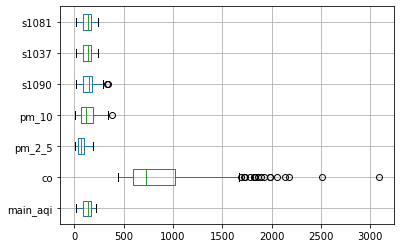

In [294]:
df = raw
columns = [col for col in df.columns.tolist() if col != 'dt2']
boxplot = df.boxplot(column=columns, showfliers=True, vert=False)
#boxplot = df.boxplot(column=['main_aqi'])

In [295]:
from statsmodels.tsa.stattools import acf

# Accuracy metrics
def forecast_accuracy(forecast, actual, return_type = 'all'):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    if return_type == 'all':
        return({'RMSE':round(rmse,2) ,'MAE': round(mae,2),
#             'mape':mape,'me':me,  
#             'mpe': mpe ,'corr':corr, 
#             'minmax':minmax
           })
    
    elif return_type == 'rmse':
        return rmse
    elif return_type == 'mae':
        return mae

######################################################################################################################
# Convert and revert matrix
def convert2matrix_11(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):     
        d=i+look_back  
        X.append(data_arr[i:d])
        Y.append(data_arr[d])
    return np.array(X), np.array(Y)

def convert2matrix_1M(data_arr, look_back, look_forward = 1):
    X, Y =[], []
    for i in range(len(data_arr)-look_back-look_forward+1):     
        d=i+look_back  
        X.append(data_arr[i:d])
        Y.append(data_arr[d : d + look_forward ])
    return np.array(X), np.array(Y)

def convert2matrix_MM(data_arr, look_back, look_forward, feature_matrix):
    X, Y =[], []
    for i in range(len(data_arr)-look_back-look_forward+1):     
        d=i+look_back  
        list_to_append = []
#         list_to_append += [data_arr[i:d]] # COMMENT THIS LINE IF DONT WANT TO USE MAIN AQI
        for j in range(len(feature_matrix)):
            list_to_append += [feature_matrix[j][i:d]]
        X.append(list_to_append)
        Y.append(data_arr[d : d + look_forward ])
    return np.array(X), np.array(Y)

# Revert shifted array to avg, max and min array
def reverted_matrix_1M(converted_matrix, look_back, look_forward) : 
    len_before_convert =  len(converted_matrix ) + look_back + look_forward -1
    list_count     = np.zeros(len_before_convert - look_back) 
    list_cum_sum   = np.zeros(len_before_convert - look_back) 
    list_max       = np.zeros(len_before_convert - look_back) 
    list_min       = np.zeros(len_before_convert - look_back) 
    list_min       = list_min + 999999999
    list_avg       = np.zeros(len_before_convert - look_back) 
    list_stimulate = np.arange(len_before_convert)
    temp, index_matrix = convert2matrix_1M(list_stimulate,look_back,look_forward)
    index_matrix = index_matrix - look_back
    for i in range(converted_matrix.shape[0]):
        for j in range (converted_matrix.shape[1]):
            list_cum_sum  [index_matrix[i,j]] +=  converted_matrix[i,j]
            list_max      [index_matrix[i,j]] = max ( list_max[index_matrix[i,j]] , converted_matrix[i,j])
            list_min      [index_matrix[i,j]] = min ( list_min[index_matrix[i,j]] , converted_matrix[i,j])
            list_count[index_matrix[i,j]] += 1

    for i in range(len(list_avg)):
        list_avg[i] = list_cum_sum[i] / list_count[i]
    return list_avg, list_max, list_min

######################################################################################################################
# Split and reshape train/test data
def split_test_train(dataset, feature_output, cut_off, look_back = 24, look_forward = 1, 
                     split_type = '11', feature_input = []):
    train = dataset[feature_output][:cut_off]
    # test  = dataset[feature_output][cut_off:] # No overlapped
    test = dataset[feature_output][cut_off - look_back - look_forward +1:] #overlapped 
    # normalize data
    trainX, trainY, testX, testY = [], [], [], []
    in_dim, out_dim = 0,0
    if split_type == '11':
        print('IO type: 1 feature => 1 output')
        # Convert dataset into right shape
        trainX, trainY = convert2matrix_11(train, look_back)
        testX , testY  = convert2matrix_11(test, look_back)
        # Reshape input to be [samples, features, size]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))    
        in_dim, out_dim  = trainX.shape[1:], look_forward
    elif split_type == '1M':
        print('IO type: 1 feature => M output')
        # Convert dataset into right shape
        trainX, trainY = convert2matrix_1M(train, look_back, look_forward)
        testX, testY   = convert2matrix_1M(test, look_back, look_forward)
        # Reshape input to be [samples, features, size]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))    
        in_dim, out_dim  = trainX.shape[1:], trainY.shape[1]
    elif split_type == 'MM':
        print('IO type: M feature => M output')
        feature_matrix_train = []
        feature_matrix_test  = []
        for selected_feature_name in feature_input:
            print('Add feature:',selected_feature_name)
            feature_matrix_train += [ dataset[selected_feature_name][:cut_off]                                ]
            feature_matrix_test  += [ dataset[selected_feature_name][cut_off - look_back - look_forward +1:]  ]
        trainX, trainY = convert2matrix_MM(train, look_back, look_forward, feature_matrix_train)
        testX , testY  = convert2matrix_MM(test , look_back, look_forward, feature_matrix_test)
        in_dim, out_dim  = trainX.shape[1:], trainY.shape[1]


    print('train size:', len(train), 'test size:', len(test))
    print('trainX shape:', trainX.shape, 'trainY shape:', trainY.shape)
    print('testX  shape:', testX.shape , 'testY  shape:', testY.shape )
    return trainX, trainY, testX, testY, in_dim, out_dim, len(test)

def split_prediction_set(prediction_set, percent = 0.5):
    X = []
    for i in range( prediction_set.shape[0]):
        list_to_append =[]
        for j in range( int(prediction_set.shape[1] * percent)):
            list_to_append += [prediction_set[i,j]]
        X.append(list_to_append)
    return np.array(X)

    
def plot_prediction(testY, test_predict, look_back = 0):
    len_prediction=[x for x in range(len(testY) - look_back)]
    plt.figure(figsize=(20,4))
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'r', marker = '*', label="prediction")
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.title('Actual & Prediction values')
    plt.ylabel('Main AQI', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

def log_errors(train_actual, test_actual, train_predict, test_predict):
    print("Train MSE: ", mean_squared_error(np.reshape(train_actual, -1), np.reshape(train_predict, -1)))
    print("Test MSE: ", mean_squared_error(np.reshape(test_actual, -1), np.reshape(test_predict, -1)))
    print("Train MAE: ", mean_absolute_error(np.reshape(train_actual, -1), np.reshape(train_predict, -1)))
    print("Test MAE: ", mean_absolute_error(np.reshape(test_actual, -1), np.reshape(test_predict, -1)))


In [297]:
# Data Standardization
from sklearn import preprocessing
features = [col for col in df.columns.tolist() if col != 'dt2']
scaled_df = df[features]
train_data = df.iloc[:cut_off, :][features]
train_means = train_data.mean().tolist()
train_stds = train_data.std().tolist()
scaled_df = (scaled_df - train_means)/train_stds
# using SkLearn standard scaler
# scaler = preprocessing.StandardScaler().fit(train_data)
# scaled_data = scaler.transform(scaled_df)
# scale data into [0,1]
# min_max_scaler = preprocessing.MinMaxScaler().fit_transform(scaled_df)
# scaled_data = min_max_scaler
# for i, feature in enumerate(features):
#     scaled_df[feature] = scaled_data[:,i]
print(features)
scaled_df.describe()

['main_aqi', 'co', 'pm_2_5', 'pm_10', 's1090', 's1037', 's1081']


,main_aqi,co,pm_2_5,pm_10,s1090,s1037,s1081
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.181845,-0.069874,0.126289,0.127030,0.166090,0.218372,0.155540
std,0.968022,0.926610,0.969689,0.972515,0.956808,0.993816,0.965046
min,-2.062747,-1.162118,-1.532388,-1.472953,-1.921966,-1.992676,-2.099406
25%,-0.608317,-0.754080,-0.689844,-0.690157,-0.643508,-0.600938,-0.655550
50%,0.376297,-0.381978,0.043084,0.032527,0.339920,0.423535,0.349907
75%,1.036038,0.402348,0.881819,0.867272,0.864416,1.042085,0.969383
max,1.975670,5.930280,3.048778,3.442681,3.421331,2.356503,2.284579


In [302]:
# Statistics method
look_back = 24
look_forward = 12

feature = ''

# data_length = len(df[feature])
# print("Data length", data_length)
cut_off = int( len(df)*0.75 )
# train = df[feature][: cut_off]
# test = df[feature][cut_off:]
start = cut_off
end = data_length -1

######################################################################################################################
# ANN | RNN | LSTM method
feature_input  = ['main_aqi']
feature_output = 's1037' # for ANN

# feature_input  = ['main_aqi']
# feature_output = 's1081' # for ANN


train_ori = df[feature_output][: cut_off - look_back]
test_ori  = df[feature_output][cut_off - look_back:]
#print(train_ori, test_ori)
trainX, trainY, testX, testY, in_dim, out_dim, len_test = None, None, None, None, None, None, None

# Input-output selection:
# 'A' 1 feature => 1 output
# 'B' 1 feature => M output
# 'C' N feature => M output
io_selection = 'B'

if   io_selection == 'A':
    trainX, trainY, testX, testY, in_dim, out_dim, len_test = split_test_train(df,
        feature_output, cut_off, look_back, look_forward = 1           ,split_type ='11',feature_input = [])
elif io_selection == 'B':
    trainX, trainY, testX, testY, in_dim, out_dim, len_test = split_test_train(scaled_df,
        feature_output, cut_off, look_back, look_forward = look_forward,split_type ='1M',feature_input = [])
elif io_selection == 'C':
    trainX, trainY, testX, testY, in_dim, out_dim, len_test = split_test_train(df,
        feature_output, cut_off, look_back, look_forward = look_forward,split_type ='MM',feature_input = feature_input)
print("in_dim", in_dim)
print("out_dim", out_dim)
print("len_test", len_test)
trainY

IO type: 1 feature => M output
train size: 540 test size: 215
trainX shape: (505, 1, 24) trainY shape: (505, 12)
testX  shape: (180, 1, 24) testY  shape: (180, 12)
in_dim (1, 24)
out_dim 12
len_test 215


array([[ 0.75213951,  0.71348014,  0.67482077, ...,  0.73280983,
         0.28822708, -0.40764157],
       [ 0.71348014,  0.67482077,  0.61683172, ...,  0.28822708,
        -0.40764157, -0.71691653],
       [ 0.67482077,  0.61683172,  0.59750203, ..., -0.40764157,
        -0.71691653, -0.83289464],
       ...,
       [ 0.86811762,  0.96476604,  1.0227551 , ...,  0.30755676,
         0.03694118, -0.1176963 ],
       [ 0.96476604,  1.0227551 ,  1.08074415, ...,  0.03694118,
        -0.1176963 , -0.2530041 ],
       [ 1.0227551 ,  1.08074415,  1.11940352, ..., -0.1176963 ,
        -0.2530041 , -0.27233378]])

In [21]:
from keras.models import Sequential, load_model
from keras.layers import Dense, SimpleRNN, Reshape, LSTM, Dropout
from keras.callbacks import EarlyStopping
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer, SigmoidLayer, TanhLayer, ReluLayer
from pybrain.structure import FullConnection
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import pyrenn as prn
from tensorflow.keras.optimizers import Adam

# Plot
def plot_model_loss(history):
#     plt.figure(figsize=(20,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [281]:
# Original model
print(f"Look_back: {look_back}, in_dim: {in_dim}, out_dim: {out_dim}")
def model_ann(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(Dense(units= look_back, input_dim= in_dim, activation="relu")) # Note: in_dim, NOT in_shape
    model.add(Dense(2 * out_dim, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer=Adam(learning_rate=0.001),metrics = ['mse', 'mae'])
    return model

def model_cfnn(in_dim, out_dim, hidden_dim):
    n = FeedForwardNetwork()
    inLayer = LinearLayer(in_dim)
    hiddenLayer = TanhLayer(hidden_dim)
    outLayer = LinearLayer(out_dim)
    
    n.addInputModule(inLayer)
    n.addModule(hiddenLayer)
    n.addOutputModule(outLayer)
    
    in_to_hidden = FullConnection(inLayer, hiddenLayer)
    hidden_to_out = FullConnection(hiddenLayer, outLayer)
    in_to_out = FullConnection(inLayer, outLayer)

    n.addConnection(in_to_hidden)
    n.addConnection(hidden_to_out)
    n.addConnection(in_to_out)
    
    n.sortModules()
    return n

def model_esn(look_back, in_dim, out_dim):
    esn = PredictionESN(n_input=in_dim[1], n_output=out_dim, n_reservoir=35, leakingRate=0.5, 
                        regressionParameters=[1e-2], solver="lsqr", feedback=False)
    return esn

def model_rnn_using_pout(look_back, in_dim, out_dim):
    trainX_rnn = trainX.reshape(trainX.shape[1] * trainX.shape[2], trainX.shape[0])
    testX_rnn  = testX .reshape(testX.shape[1]  * testX.shape[2], testX.shape[0])
    train_rnn = trainY.reshape(trainY.shape[1], trainY.shape[0])
    delayOut = list(range(1,13))
    net = prn.CreateNN([24,24,12],dIn=[],dIntern=[],dOut=[12])
    net = prn.train_LM(trainX_rnn,train_rnn,net,verbose=True,k_max=50,E_stop=0.3)
    return net
    
def model_rnn(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(SimpleRNN(units= look_back, input_shape= in_dim, activation="relu"))
    model.add(Dense(round(look_back * 1), activation='relu'))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

def model_lstm(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(LSTM(units= look_back*1, input_shape= in_dim, activation='relu'))
    model.add(Dense(round(look_back * 1), activation='relu'))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

###############################
# New Model

def model_ann2(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(Dense(units= look_back, input_dim= in_dim, activation="relu")) # Note: in_dim, NOT in_shape
    model.add(Dense(round(look_back * 2), activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

def model_rnn2(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(SimpleRNN(units= look_back, input_shape= in_dim, activation="relu"))
    model.add(Dense(round(look_back * 2), activation='relu'))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

def model_lstm2(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(LSTM(units= look_back*1, input_shape= in_dim, activation='relu'))
    model.add(Dense(round(look_back * 2), activation='relu'))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

###########################################
def model_ann3(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(Dense(units= look_back, input_dim= in_dim, activation="relu")) # Note: in_dim, NOT in_shape
    model.add(Dense(round(look_back * 1), activation='relu'))
    model.add(Dense(round(look_back * 1), activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

def model_rnn3(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(SimpleRNN(units= look_back, input_shape= in_dim, activation="relu"))
    model.add(Dense(round(look_back * 1), activation='relu'))
    model.add(Dense(round(look_back * 1), activation='relu'))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

def model_lstm3(look_back, in_dim, out_dim):
    model=Sequential()
    model.add(LSTM(units= look_back*1, input_shape= in_dim, activation='relu'))
    model.add(Dense(round(look_back * 1), activation='relu'))
    model.add(Dense(round(look_back * 1), activation='relu'))
    model.add(Dense(out_dim))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

Look_back: 24, in_dim: (1, 24), out_dim: 12


In [310]:
save_models = {}

In [311]:
#models = ['cfnn', 'esn', 'rnn', 'ann', 'rnn_po']
models = ['esn']

# hybrid model: CFNN + RNN + ESN + RNN using previous outputs
trainX_2D = trainX.reshape(trainX.shape[0],  trainX.shape[1] * trainX.shape[2])
testX_2D  = testX .reshape(testX.shape[0] ,  testX.shape[1]  * testX.shape[2])
#CFNN
if 'cfnn' in models:
    print("--------Traning CFNN model------------")
    if 'cfnn' in save_models.keys():
        cfnn.reset()
    cfnn_model = model_cfnn(24, 12, 12)
    cfnn_trainingY = np.zeros((trainY.shape[0], trainY.shape[1]))
    cfnn_testingY = np.zeros((testY.shape[0], testY.shape[1]))
    ds = SupervisedDataSet(trainX_2D.shape[1], trainY.shape[1])
    for i in range(trainY.shape[0]):
        ds.addSample(trainX_2D[i], trainY[i])
    trainer = BackpropTrainer(cfnn_model, ds, learningrate = 0.001)
    trainer.trainUntilConvergence(maxEpochs=200 ,verbose=True)
    save_models['cfnn'] = cfnn_model

#ESN
if 'esn' in models:
    print("-----------Training ESN model------------")
    esn = model_esn(look_back, in_dim, out_dim)
    esn.fit(trainX_2D, trainY, transientTime="Auto", verbose=True)
    save_models['esn'] = esn
             
#RNN using previous outputs
if 'rnn_po' in models:
    print("----------Training RRN using previous outputs model----------")
    trainX_rnn = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).T
    testX_rnn  = testX .reshape(testX.shape[0], testX.shape[1]  * testX.shape[2]).T
    train_Y_rnn = trainY.T
    delayOut = list(range(1,13))
    rnn_pout_model = prn.CreateNN([24,12,12],dIn=[0,1,2,3],dIntern=[],dOut=[1,2,3])
    rnn_pout_model = prn.train_LM(trainX_rnn, train_Y_rnn, rnn_pout_model, verbose=True, k_max=20, E_stop=0.3)
    save_models['rnn_po'] = rnn_pout_model

#RNN
if 'rnn' in models:
    print("----------Training RNN model------------")
    rnn_model = model_rnn(look_back, in_dim, out_dim)
    rnn_model.fit(trainX, trainY, epochs=200, batch_size=10, verbose=1, validation_data=(testX,testY), shuffle=False)
    save_models['rnn'] = rnn_model

#ANN
if 'ann' in models:
    print("----------Training RNN model------------")
    in_dim_2D = in_dim[0] * in_dim[1]
    ann_model = model_ann(look_back, in_dim_2D, out_dim)
    ann_model.summary()
    history = ann_model.fit(trainX_2D,trainY, epochs=200, batch_size=10, verbose=1, 
                        validation_data=(testX_2D,testY),shuffle=False)
    save_models['ann'] = ann_model


-----------Training ESN model------------


100% (480 of 480) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [312]:
prediction_results = {}
for name, model in save_models.items():
    if name == 'cfnn':
        train_predict = np.zeros((trainY.shape[0], trainY.shape[1]))
        test_predict = np.zeros((testY.shape[0], testY.shape[1]))
        for n in range(0, trainY.shape[0]):
            train_predict[n] = save_models[name].activate(trainX_2D[n])
        for m in range(0, testY.shape[0]):
            test_predict[m] = save_models[name].activate(testX_2D[m])
    elif name == 'rnn_po':
        train_predict = prn.NNOut(trainX_rnn, save_models[name]).T
        test_predict = prn.NNOut(testX_rnn, save_models[name]).T
    elif name in ['lstm', 'rnn']:
        train_predict = save_models[name].predict(trainX)
        test_predict = save_models[name].predict(testX)
    else:
        train_predict = save_models[name].predict(trainX_2D)
        test_predict = save_models[name].predict(testX_2D)
    print(f"{name} model errors | train predicts shape: {train_predict.shape}, test predicts shape: {test_predict.shape}")
    print()
    prediction_results[name] = {}
    prediction_results[name]['train_predict'] = train_predict
    prediction_results[name]['test_predict'] = test_predict
    log_errors(trainY, testY, train_predict, test_predict)
    print()

esn model errors | train predicts shape: (505, 12), test predicts shape: (180, 12)

Train MSE:  0.23883120056310955
Test MSE:  0.2837028230693851
Train MAE:  0.36773241634147485
Test MAE:  0.4259028678771279



In [313]:
save_models

{'esn': <easyesn.PredictionESN.PredictionESN at 0x22f84d89888>}

In [162]:
hybrid_trainingX = np.stack([cfnn_trainingY, esn_trainingY, rnn_pout_trainingY, rnn_trainingY], axis=0).reshape(4, 6060).T
hybrid_testingX = np.stack([cfnn_testingY, esn_testingY, rnn_pout_tesingY, rnn_testingY], axis=0).reshape(4, 2160).T
hybrid_trainingY = trainY.reshape(-1)
hybrid_testingY = testY.reshape(-1)
print("-----------Training Hybrid model-----------")
hybrid_model = model_ann(4, 4, 1)
hybrid_history = hybrid_model.fit(hybrid_trainingX, hybrid_trainingY, epochs=100, batch_size=20, verbose=1, 
                                  validation_data=(hybrid_testingX, hybrid_testingY),shuffle=False)


Plot of esn Neural-network model predition: 

Averaged bias: {'RMSE': 0.46, 'MAE': 0.39}
Last bias    : {'RMSE': 0.59, 'MAE': 0.51}


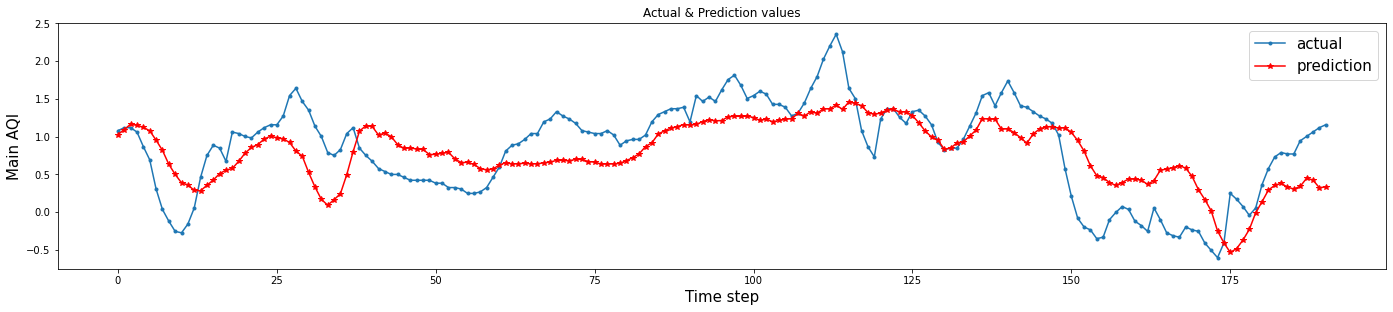

In [314]:
#Plot
#test_predict = hybrid_test_predict.reshape(180,12)
for model, result in prediction_results.items():
    test_predict = result['test_predict']
    result_avg_testY       , result_max_testY       , result_min_testY        = None, None, None
    result_avg_test_predict, result_max_test_predict, result_min_test_predict = None, None, None
    print(f"\n\033[1mPlot of {model} Neural-network model predition:\033[0m \n")
    if io_selection == 'A':
        plot_prediction(testY, test_predict)
    elif io_selection == 'B' or io_selection == 'C':
        result_avg_testY       , result_max_testY       , result_min_testY        = reverted_matrix_1M(
            testY       , look_back, look_forward)
        result_avg_test_predict, result_max_test_predict, result_min_test_predict = reverted_matrix_1M(
            test_predict, look_back, look_forward)
        print('Averaged bias:',  forecast_accuracy( result_avg_testY, result_avg_test_predict) )#Calculate for average recs
        print('Last bias    :',forecast_accuracy( testY[-1,:]     , test_predict[-1,:]     ) )#Calculate for last    recs

        plot_prediction(result_avg_testY, result_avg_test_predict)

In [ ]:
print('\n\033[1mPlot of Neural-network model predition with time index:\033[0m \n')
if io_selection == 'A':
    feature = 'main_aqi'
    index_data_model  = pd.date_range(df[feature_output].index[-len_test + look_back], periods = len_test - look_back, 
                                      freq=freq_metric)

    # postion_from_last = -1 # Used for multi_output_model, keep default value -1 for sngle_output model
    prediction_with_index = pd.Series(test_predict.reshape(-1), index = index_data_model) # Single_model

    plt.figure(figsize=(20,4))
    plt.plot(df[feature][:cut_off], label = 'train')
    plt.plot(df[feature][cut_off:], label = 'test', color = 'green')
    plt.plot(prediction_with_index, label = 'prediction', color = 'red')
    plt.legend(loc = 'upper left')
elif io_selection == 'B' or io_selection == 'C':
#     Original index
    index_data_model  = pd.date_range(df[feature_output].index[-len_test + look_back], periods = len_test - look_back, 
                                      freq=freq_metric)

    t_testY        = pd.Series(result_avg_testY,        index = index_data_model)
    t_predictY_avg = pd.Series(result_avg_test_predict, index = index_data_model)
    t_predictY_max = pd.Series(result_max_test_predict, index = index_data_model)
    t_predictY_min = pd.Series(result_min_test_predict, index = index_data_model)

    postion_from_last = -1 # Stick with -1 or negative number
    index_data_forecast = pd.date_range(df[feature_output].index[-look_forward + postion_from_last +1], 
                                        periods = look_forward , freq=freq_metric)
    t_predictY_forcast = None
#     t_predictY_forcast  = pd.Series(test_predict[-1,:], index = index_data_forecast) # Ok but stick to last record
    if model_selection == 0: # ANN
        t_predictY_forcast  = pd.Series(model.predict([testX_2D[postion_from_last,:].tolist()]).reshape(-1),
                                index = index_data_forecast) # Move forecast around
    else:
        t_predictY_forcast  = pd.Series(model.predict([testX[postion_from_last,:].tolist()]).reshape(-1),
                                index = index_data_forecast) # Move forecast around
    plt.figure(figsize=(20,4))
    plt.plot(train_ori, label = "Train area")
    plt.plot(test_ori, label = "Test area")
    plt.plot(t_testY, label = 'Test actual')
    plt.plot(t_predictY_avg, label = 'Predict average')

    plt.fill_between(t_predictY_avg.index, 
                     t_predictY_min, 
                     t_predictY_max, 
                     color='k', alpha=.15)

    plt.plot(t_predictY_forcast, label = 'Last predict n='+str(look_forward), color = 'black')
    plt.legend(loc = "upper left")